# Inleveropdracht 2: Logistic Regression & Naïve Bayes
#### Naam: Lucas van der Horst
#### Studentnummer: 1757028

## Deel I: Logistic Regression

1. Neem uit de vorige opdracht over: je tweet cleaning functie en de functie die een dictionary van frequencies maakt.

In [1]:
import nltk
import re
import string

nltk.download('stopwords')

def clean_tweet(tweet):
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/[^\s]*[\r]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # Remove `RT`
    tweet = re.sub(r'RT[\s]+', '', tweet)

    # tokenize with nltk TweetTokenizer
    tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)

    # remove stop words and functions
    filter = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [word for word in tokens if word not in filter]

    # stemming
    stemmer = nltk.stem.PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens


def make_frequency_dictionary(cleaned_tweets, labels):
    counter = {}

    # count the positive words
    for tweet, label in zip(cleaned_tweets, labels):
        for word in tweet:
            key = (word, label.item())
            counter.setdefault(key, 0)
            counter[key] += 1

    return counter

[nltk_data] Downloading package stopwords to /home/horstl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2. Laad de tweets uit de Twitter samples, en splits de data in 80% trainings- en 20% testdata, let op dat je data balanced blijft tussen positive en negative tweets.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the twitter dataset
nltk.download('twitter_samples')
twitter_samples = nltk.corpus.twitter_samples
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

# Combine the positive and negative and create a label
tweets = positive_tweets + negative_tweets
labels = np.zeros((len(tweets), 1))
labels[:len(positive_tweets)] = 1

# Split the data random in 80% train and 20% test
tweets_train, tweets_test, labels_train, labels_test = train_test_split(tweets, labels, test_size=0.2)

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/horstl/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


3. Maak een frequency dictionary van alleen de trainingsdata.
Test je code: deze dictionary zou 11427 entries moeten hebben.

In [3]:

train_freq_dict = make_frequency_dictionary(map(clean_tweet, tweets_train), labels_train)

print(len(train_freq_dict))

11408


4. Voeg een sigmoid functie toe voor de logistic regression. Zorg ervoor dat deze ook werkt op een array.

Test je functie in elk geval met deze waarden: `sigmoid(0)` = 0.5, `sigmoid(4.92)` = 0.9927537604041685

In [4]:
from collections.abc import Iterable
import numpy as np

def sigmoid(z):
    if isinstance(z, Iterable):
        return np.array([sigmoid(z_i) for z_i in z])
    return 1 / (1 + np.exp(-z))

assert sigmoid(0) == 0.5
assert sigmoid(4.92) == 0.9927537604041685

5. Implementeer een gradient descent functie volgens de uitleg hieronder, en leg zo goed mogelijk in je eigen woorden uit wat de code doet.

In [5]:
from typing import Tuple

def gradient_descent(x: np.ndarray, y: np.ndarray, theta: np.ndarray, apha: float, num_iters: int) -> Tuple[float, np.ndarray]:
    """
    :param x: matrix of features which is (m,n+1), last column is filled with 1s for bias
    :param y: corresponding labels of the input matrix x, dimensions (m,1)
    :param theta: weight vector of dimension (n+1,1)
    :param apha: learning rate
    :param num_iters: number of iterations you want to train your model for
    :return: the last cost and theta vector (learned weights)
    """
    m = x.shape[0]
    for i in range(num_iters):
        z = np.dot(x, theta)  # logits
        h = sigmoid(z) # prediction
        J = -1 / m * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h))) # cost function
        theta = theta - (apha / m) * np.dot(x.T, (h - y)) # update the weights

        print(f"Iteration: {i} Cost: {J.item()}")
    
    return J.item(), theta

Wat er hier gebeurd is dat de weights ($\theta$) worden elke iteratie een klein beetje aangepast om het verschil tussen de huidige voorspelling en het doel te verkleinen.  

Het werkelijk voorspellen met dit model gebeurd in de eerste twee stappen, namelijk de dot product nemen van de features en de weights, en deze door de sigmoid functie halen.  
Daarna wordt er met `np.dot(x.T, (h - y))` het verschil tussen de voorspelling en het doel berekend als een soort hoek/gradient waar de weights naartoe moeten worden aangepast.  
Daarna wordt dit genormaliseerd door te delen door het aantal samples, en wordt de grootte van de stap geschaalt met de learning rate.  
Deze stap wordt dan van de weights afgetrokken om de weights te updaten.  

Het berekenen van de cost (`J`) is niet nodig voor het voorspellen, maar is wel handig om te zien of het model goed werkt.

6. Test je gradient descent functie met de volgende random test data.

In [6]:
# Generate random data
np.random.seed(1)
# X input is 10 x 3 met 1 voor de bias terms
test_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y labels zijn 10 x 1
test_Y = (np.random.rand(10, 1) > 0.35).astype(float)

gradient_descent(test_X, test_Y, np.zeros((3, 1)), 1e-8, 700)

Iteration: 0 Cost: 0.6931471805599453
Iteration: 1 Cost: 0.69305407419931
Iteration: 2 Cost: 0.6929615149729415
Iteration: 3 Cost: 0.6928694989001035
Iteration: 4 Cost: 0.6927780220289215
Iteration: 5 Cost: 0.6926870804361839
Iteration: 6 Cost: 0.6925966702271453
Iteration: 7 Cost: 0.6925067875353309
Iteration: 8 Cost: 0.692417428522341
Iteration: 9 Cost: 0.6923285893776581
Iteration: 10 Cost: 0.6922402663184535
Iteration: 11 Cost: 0.6921524555893973
Iteration: 12 Cost: 0.6920651534624666
Iteration: 13 Cost: 0.6919783562367572
Iteration: 14 Cost: 0.6918920602382954
Iteration: 15 Cost: 0.691806261819851
Iteration: 16 Cost: 0.6917209573607516
Iteration: 17 Cost: 0.691636143266698
Iteration: 18 Cost: 0.6915518159695805
Iteration: 19 Cost: 0.6914679719272961
Iteration: 20 Cost: 0.6913846076235677
Iteration: 21 Cost: 0.6913017195677637
Iteration: 22 Cost: 0.691219304294718
Iteration: 23 Cost: 0.6911373583645531
Iteration: 24 Cost: 0.6910558783625025
Iteration: 25 Cost: 0.6909748608987345
It

(0.6709497038162118,
 array([[4.10713435e-07],
        [3.56584699e-04],
        [7.30888526e-05]]))

7. Nu gaan we de feature extraction erbij doen.  
Gebruik je eerder gemaakte tweet cleaning functie en de frequency dictionary uit stap 3, om een vector te creëren van een tweet, met twee features erin.  
De vector heeft dimensies (1,3) en bevat een 1 als bias, dan de positieve en dan de negatieve feature value.  
Feature values zijn simpelweg de word counts uit de frequency dictionary van alle woordstammen in de tweet, per label (positief of negatief) bij elkaar opgeteld.  
Dus bijvoorbeeld voor het eerste element uit de training set zijn de opgetelde positive counts 3133 en de negative counts 61.  
Test je functie door te checken dat met als input `train_x[0]` de output is: `[[1.000e+00 3.133e+03 6.100e+01]]`

In [7]:
train_x = np.ones((len(tweets_train), 3))
train_x[:, 1] = [sum([train_freq_dict.get((word, 1), 0) for word in tweet]) for tweet in map(clean_tweet, tweets_train)]
train_x[:, 2] = [sum([train_freq_dict.get((word, 0), 0) for word in tweet]) for tweet in map(clean_tweet, tweets_train)]
# [bias, positive, negative]

print(train_x[0])

[1.000e+00 1.202e+03 4.010e+02]


8. Train je model:  
Stapel de features voor alle training examples in een matrix X (iedere feature vector is één row in de matrix), en alle training labels in een matrix Y.
Gebruik je hiervoor geïmplementeerde gradient descent functie op die matrix. Neem als learning rate 1e-9 en doe 1500 iteraties.

In [8]:
train_y = np.array(labels_train).reshape(len(labels_train), 1)
last_cost, trained_model = gradient_descent(train_x, train_y, np.zeros((3, 1)), 1e-9, 1500)

Iteration: 0 Cost: 0.6931471805599603
Iteration: 1 Cost: 0.6920226860858549
Iteration: 2 Cost: 0.6909016117011819
Iteration: 3 Cost: 0.6897839461644496
Iteration: 4 Cost: 0.6886696782321019
Iteration: 5 Cost: 0.6875587966591111
Iteration: 6 Cost: 0.6864512901996078
Iteration: 7 Cost: 0.6853471476075168
Iteration: 8 Cost: 0.6842463576371793
Iteration: 9 Cost: 0.6831489090440132
Iteration: 10 Cost: 0.6820547905851309
Iteration: 11 Cost: 0.6809639910200102
Iteration: 12 Cost: 0.6798764991111189
Iteration: 13 Cost: 0.6787923036245809
Iteration: 14 Cost: 0.6777113933308238
Iteration: 15 Cost: 0.6766337570052247
Iteration: 16 Cost: 0.6755593834287733
Iteration: 17 Cost: 0.674488261388718
Iteration: 18 Cost: 0.6734203796792189
Iteration: 19 Cost: 0.6723557271020062
Iteration: 20 Cost: 0.6712942924670287
Iteration: 21 Cost: 0.6702360645930989
Iteration: 22 Cost: 0.6691810323085451
Iteration: 23 Cost: 0.6681291844518521
Iteration: 24 Cost: 0.6670805098723036
Iteration: 25 Cost: 0.66603499743063

9. Maak een scatter plot van de samples:  
Gebruik de scatter functie van matplotlib.pyplot, met de positive sum op de x-as en de negative sum op de y-as; toon positief geclassificeerde tweets als een groene, en negatief geclassificeerde tweets als een rode punt.  
Optioneel: probeer in de grafiek met behulp van de geleerde een lijn te tekenen die de geleerde scheiding weergeeft.

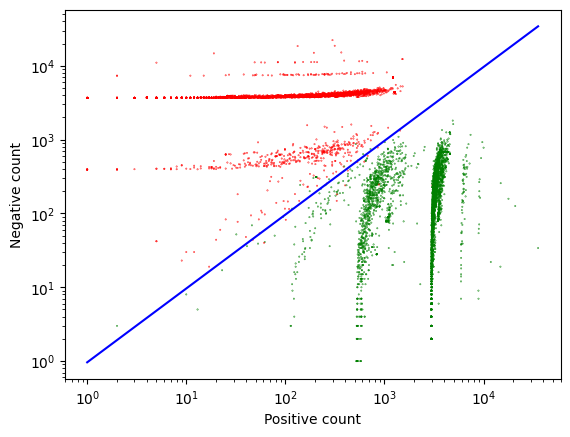

In [9]:
import matplotlib.pyplot as plt

def plot_samples(x, y, thetha):
    plt.scatter(x[:, 1], x[:, 2], c=['green' if label == 1 else 'red' for label in y], s=0.1)

    # Plot the decision boundary
    boundary_x = np.arange(1, np.max(train_x[:, 1]), 1)
    boundary_y = (-thetha[0] - thetha[1] * boundary_x) / thetha[2]
    plt.plot(boundary_x, boundary_y, c='blue')

    plt.xlabel('Positive count')
    plt.ylabel('Negative count')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

plot_samples(train_x, train_y, trained_model)

10. Maak een prediction function:  
Implementeer een functie om het sentiment van tweets te voorspellen.  
Input: tweet, freqs, theta.  
Output: De waarschijnlijkheid dat de tweet positief of negatief is.  
Pas de geleerde weights toe op de features om de logits te verkrijgen;  
Pas de sigmoid toe op de logits om het voorspelde sentiment te krijgen (een waarde tussen 0 en 1).  
Test je functie met deze tweets:  
`"I am happy" -> 0.519275`  
`"I am bad" -> 0.494347`  
`"this movie should have been great." -> 0.515980`  
`"great" -> 0.516065`  
`"great great" -> 0.532097`  
`"great great great" -> 0.548063`  
`"great great great great" -> 0.563930`  

In [10]:
def predict_tweet(tweet: str, freq_dict: dict, theta: np.ndarray) -> int:
    """
    :param tweet: a string
    :param freq_dict: a dictionary corresponding to the frequencies of each tuple (word, label)
    :param theta: weight vector of dimension (3,1)
    :return: the probability of a tweet being positive or negative
    """
    x = np.zeros((1, 3))
    x[0, 0] = 1

    for word in clean_tweet(tweet):
        x[0, 1] += freq_dict.get((word, 1), 0)
        x[0, 2] += freq_dict.get((word, 0), 0)

    pred = sigmoid(np.dot(x, theta))
    return pred.item()

for tweet in [
    "I am happy",
    "I am bad",
    "this movie should have been great.",
    "great",
    "great great",
    "great great great",
    "great great great great",
]:
    print(f'"{tweet}" -> {predict_tweet(tweet, train_freq_dict, trained_model)}')

"I am happy" -> 0.5203448319450585
"I am bad" -> 0.4930787453216342
"this movie should have been great." -> 0.5156726287248795
"great" -> 0.5154878006904033
"great great" -> 0.5309458938362887
"great great great" -> 0.5463448299394831
"great great great great" -> 0.561655594955819


11. Test de accuracy van je model:  
Input:  
`test_x`: Een list van tweets  
`test_y`: Een (m, 1) vector met de corresponderende labels bij de tweets  
`freqs`: Een dictionary met de frequency van elk paar (tuple)  
`theta`: Weight vector van dimensie (3, 1)  
Output:  
`accuracy`: (aantal tweets correct geclassificeerd)/(totaal aantal tweets)  
Op basis van de eerste 80% als trainingsdata en de laatst 20% als testdata, zou de accuracy van je logistic regression 0.995 moeten zijn.

In [11]:
def test_logistic_regression(test_x: np.ndarray, test_y: np.ndarray, freqs: dict, theta: np.ndarray):
    """
    :param test_x: matrix of features which is (m,n+1)
    :param test_y: corresponding labels of the input matrix x, dimensions (m,1)
    :param freqs: frequency dictionary of each word for each pair (word, label)
    :param theta: weight vector of dimension (n+1,1)
    :return: the accuracy of the model
    """
    y_hat = sigmoid(np.dot(test_x, theta))
    y_hat[y_hat > 0.5] = 1
    y_hat[y_hat <= 0.5] = 0

    accuracy = (y_hat == test_y).sum() / len(test_x)

    return accuracy

test_x = np.ones((len(tweets_test), 3))
test_x[:, 1] = [sum([train_freq_dict.get((word, 1), 0) for word in tweet]) for tweet in map(clean_tweet, tweets_test)]
test_x[:, 2] = [sum([train_freq_dict.get((word, 0), 0) for word in tweet]) for tweet in map(clean_tweet, tweets_test)]
# [bias, positive, negative]

test_y = np.array(labels_test).reshape(len(labels_test), 1)

accuracy = test_logistic_regression(test_x, test_y, train_freq_dict, trained_model)
print(f"Logistic regression model's accuracy = {accuracy * 100:.2f}%")

Logistic regression model's accuracy = 99.20%


Dat klopt! De accuracy is afgerond 0.995.  
Laten we ook even een scatterplot van de testdata maken.

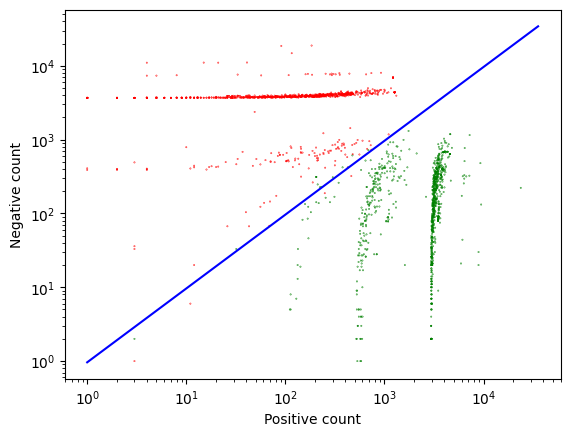

In [12]:
plot_samples(test_x, test_y, trained_model)